In [26]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from tqdm import tqdm
import torch.optim as optim
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import random

In [2]:
class AnomalyDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = [os.path.join(root_dir, img) for img in os.listdir(root_dir)]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        label = 0 if 'normal' in self.root_dir else 1  # 0 for normal, 1 for anomalous
        if self.transform:
            image = self.transform(image)
        return image, label


In [3]:
# Transforms
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

In [4]:
# Load Datasets
normal_dataset = AnomalyDataset('../../datasets/agco_front/normal', transform=transform)
anomalous_dataset = AnomalyDataset('../../datasets/agco_front/anomalous', transform=transform)

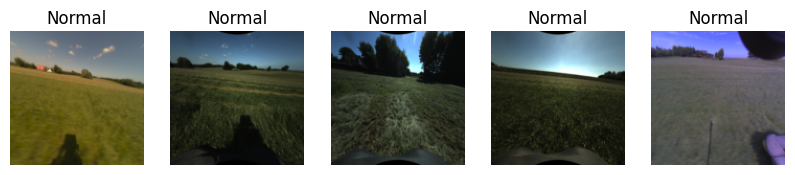

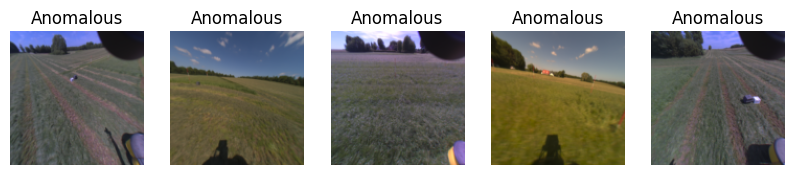

In [5]:
import matplotlib.pyplot as plt

def visualize_images(dataset, num_images=5):
    plt.figure(figsize=(10, 5))
    for i in range(num_images):
        image, label = dataset[i]
        plt.subplot(1, num_images, i + 1)
        plt.imshow(image.permute(1, 2, 0))
        plt.title("Normal" if label == 0 else "Anomalous")
        plt.axis("off")
    plt.show()

visualize_images(normal_dataset)
visualize_images(anomalous_dataset)


In [6]:
# DataLoaders
train_loader = DataLoader(normal_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(anomalous_dataset, batch_size=32, shuffle=False)

In [13]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()  # Normalize output to [0, 1] range
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
model = ConvAutoencoder()

In [10]:
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for images, _ in tqdm(dataloader):
        images = images.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    return running_loss / len(dataloader.dataset)

def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, _ in dataloader:
            images = images.to(device)
            outputs = model(images)
            loss = criterion(outputs, images)
            running_loss += loss.item() * images.size(0)
    return running_loss / len(dataloader.dataset)


In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
best_loss = float("inf")

In [15]:
num_epochs = 20
for epoch in range(num_epochs):
    train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss = evaluate(model, val_loader, criterion, device)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # Save the best model
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), "best_autoencoder_model.pth")
        print("Best model saved!")

100%|██████████| 68/68 [01:23<00:00,  1.23s/it]


Epoch [1/20], Train Loss: 0.0196, Val Loss: 0.0097
Best model saved!


100%|██████████| 68/68 [01:22<00:00,  1.21s/it]


Epoch [2/20], Train Loss: 0.0049, Val Loss: 0.0057
Best model saved!


100%|██████████| 68/68 [01:26<00:00,  1.28s/it]


Epoch [3/20], Train Loss: 0.0026, Val Loss: 0.0034
Best model saved!


100%|██████████| 68/68 [01:31<00:00,  1.34s/it]


Epoch [4/20], Train Loss: 0.0019, Val Loss: 0.0028
Best model saved!


100%|██████████| 68/68 [01:25<00:00,  1.26s/it]


Epoch [5/20], Train Loss: 0.0016, Val Loss: 0.0024
Best model saved!


100%|██████████| 68/68 [01:35<00:00,  1.41s/it]


Epoch [6/20], Train Loss: 0.0015, Val Loss: 0.0023
Best model saved!


100%|██████████| 68/68 [01:43<00:00,  1.53s/it]


Epoch [7/20], Train Loss: 0.0013, Val Loss: 0.0022
Best model saved!


100%|██████████| 68/68 [01:32<00:00,  1.37s/it]


Epoch [8/20], Train Loss: 0.0013, Val Loss: 0.0020
Best model saved!


100%|██████████| 68/68 [01:32<00:00,  1.36s/it]


Epoch [9/20], Train Loss: 0.0012, Val Loss: 0.0019
Best model saved!


100%|██████████| 68/68 [01:30<00:00,  1.33s/it]


Epoch [10/20], Train Loss: 0.0011, Val Loss: 0.0018
Best model saved!


100%|██████████| 68/68 [01:31<00:00,  1.35s/it]


Epoch [11/20], Train Loss: 0.0011, Val Loss: 0.0017
Best model saved!


100%|██████████| 68/68 [01:34<00:00,  1.38s/it]


Epoch [12/20], Train Loss: 0.0010, Val Loss: 0.0017


100%|██████████| 68/68 [01:34<00:00,  1.39s/it]


Epoch [13/20], Train Loss: 0.0010, Val Loss: 0.0017
Best model saved!


100%|██████████| 68/68 [01:30<00:00,  1.34s/it]


Epoch [14/20], Train Loss: 0.0009, Val Loss: 0.0015
Best model saved!


100%|██████████| 68/68 [01:33<00:00,  1.37s/it]


Epoch [15/20], Train Loss: 0.0009, Val Loss: 0.0016


100%|██████████| 68/68 [01:35<00:00,  1.41s/it]


Epoch [16/20], Train Loss: 0.0009, Val Loss: 0.0015
Best model saved!


100%|██████████| 68/68 [01:33<00:00,  1.38s/it]


Epoch [17/20], Train Loss: 0.0008, Val Loss: 0.0015


100%|██████████| 68/68 [01:31<00:00,  1.35s/it]


Epoch [18/20], Train Loss: 0.0008, Val Loss: 0.0015
Best model saved!


100%|██████████| 68/68 [01:32<00:00,  1.36s/it]


Epoch [19/20], Train Loss: 0.0008, Val Loss: 0.0014
Best model saved!


100%|██████████| 68/68 [01:31<00:00,  1.35s/it]


Epoch [20/20], Train Loss: 0.0007, Val Loss: 0.0014


### Testing

In [21]:
def detect_anomalies(model, dataloader, threshold, device):
    model.eval()
    labels = []
    predictions = []
    sample_images = []
    sample_preds = []
    sample_labels = []
    
    with torch.no_grad():
        for images, true_labels in tqdm(dataloader, desc="Testing"):
            images = images.to(device)
            outputs = model(images)
            losses = torch.mean((outputs - images) ** 2, dim=[1, 2, 3])
            preds = (losses > threshold).int().cpu().numpy()
            predictions.extend(preds)
            labels.extend(true_labels.numpy())

            # Save some sample images for visualization
            sample_images.extend(images.cpu())
            sample_preds.extend(preds)
            sample_labels.extend(true_labels.cpu().numpy())
    
    return labels, predictions, sample_images, sample_preds, sample_labels



In [22]:
combined_dataset = torch.utils.data.ConcatDataset([normal_dataset, anomalous_dataset])
combined_loader = DataLoader(combined_dataset, batch_size=32, shuffle=False)

Testing: 100%|██████████| 91/91 [01:49<00:00,  1.21s/it]


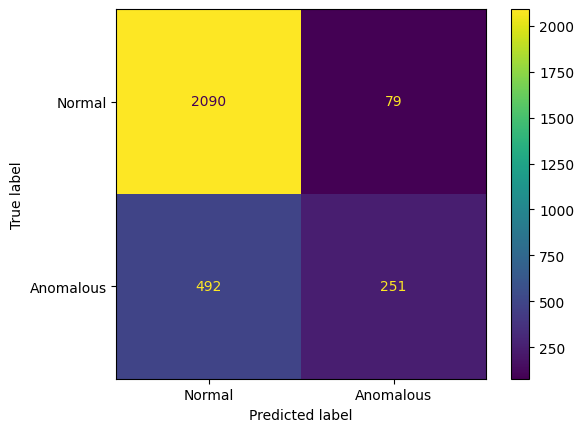

In [23]:
# Set a threshold for anomaly detection (adjusting on val loss)
threshold = 0.0014  

labels, predictions, sample_images, sample_preds, sample_labels = detect_anomalies(model, combined_loader, threshold, device)

# Confusion Matrix
cm = confusion_matrix(labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Anomalous"])
disp.plot()
plt.show()

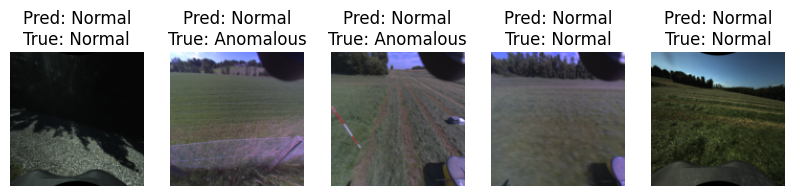

In [28]:
def visualize_predictions(images, preds, labels, num_images=5):
    # Randomly select indices for visualization
    indices = random.sample(range(len(images)), num_images)
    
    plt.figure(figsize=(10, 5))
    for i, idx in enumerate(indices):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[idx].permute(1, 2, 0))
        pred_label = "Anomalous" if preds[idx] == 1 else "Normal"
        true_label = "Anomalous" if labels[idx] == 1 else "Normal"
        plt.title(f"Pred: {pred_label}\nTrue: {true_label}")
        plt.axis("off")
    plt.show()

# Usage
visualize_predictions(sample_images, sample_preds, sample_labels)
